## Predicting House Prices
### Problem:
- **Objective**: Predict house prices. 
- **How**: Building a Feedforward Neural Network.
- **Dataset**: Various features about houses (e.g., square footage, number of bedrooms, furnished status).
- **Target variable**: House price

### Steps:
**Load the Dataset**: Housing dataset coming from Kaggle ([Link Here](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset))

**Preprocess the Data**:
  1) Convert categorical columns into numerical representations
  2) Separate features and target (price)
  3) Split data into training and testing sets
  4) Scale input features
  5) Scale target (price)
  6) Convert features and labels to tensors

**Build the Neural Network**: Feedforward Neural Network with the following layers:

*Input Layer*: Match the number of input features.

*Hidden Layers*: Two hidden layers with ReLU activation (512 and 256 units).

*Dropout Layers*: After each of the first two layers, dropout is applied with a probability of 0.3 to prevent overfitting.

*Output Layer*: One neuron for the continuous output (price).

**Train the Model**: 
 1) Use the MSE loss function and Adam optimizer. 
 2) Train for 400 epochs.
 3) Calculate and print the validation loss during training.

**Evaluate the Model**:  
 1) Calculate test loss after training.
 2) Plot training VS validation loss curves
 3) Calculate R-squared

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [153]:
housing_data = pd.read_csv('Housing.csv')

In [154]:
housing_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [155]:
housing_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']] = housing_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']].replace({'yes': 1, 'no': 0}).astype(int)

In [156]:
housing_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [157]:
housing_data['furnishingstatus']=LabelEncoder().fit_transform(housing_data['furnishingstatus'])

In [158]:
housing_data.tail()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,2
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,2
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0
544,1750000,3850,3,1,2,1,0,0,0,0,0,0,2


In [170]:
class HouseData(Dataset):
    def __init__(self, file_path, train=True, test_size=0.2, random_state=42):
        housing_data = pd.read_csv(file_path)

        # Step 1: Preprocessing categorical data
        # Convert categorical columns into numerical representations
        housing_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']] = housing_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']].replace({'yes': 1, 'no': 0}).astype(int)
        housing_data['furnishingstatus']=LabelEncoder().fit_transform(housing_data['furnishingstatus'])
        
        # Separate features and target (price)
        X=housing_data.drop("price",axis=1)
        y=housing_data["price"]

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Scale input features
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        # Scale target (price)
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Flatten after scaling
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

        if train:
            self.X = X_train_scaled
            self.y = y_train_scaled  # Normalize target
        else:
            self.X = X_test_scaled
            self.y = y_test_scaled
    
        
        # Convert features and labels to tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [171]:
csv_file = 'Housing.csv'  # Replace with the actual path to your file
train_dataset = HouseData(csv_file, train=True)
test_dataset = HouseData(csv_file, train=False)

In [172]:
class HouseNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(HouseNN, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)

        return x

In [201]:
X_train, X_val, y_train, y_val = train_test_split(train_dataset.X, train_dataset.y, test_size=0.2, random_state=42)

In [198]:
#Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features in the dataset
output_size = 1  # Predicting house prices (a single output)
model_h = HouseNN(input_size=input_size, output_size=output_size)

In [199]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_h.parameters(), lr=1e-5)

In [176]:
epochs = 400

# Lists to store losses for plotting
train_losses = np.array([])
val_losses = np.array([])

for epoch in range(epochs):
    model_h.train()
    optimizer.zero_grad()
        
    pred = model_h(X_train)
    train_loss = loss_fn(pred, y_train)

    train_loss.backward()
    optimizer.step()

    model_h.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        val_pred = model_h(X_val)
        val_loss = loss_fn(val_pred, y_val)

    # Print training and validation loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    train_losses = np.append(train_losses, train_loss.item())
    val_losses = np.append(val_losses, val_loss.item())

Epoch 0/400, Train Loss: 1.0701, Validation Loss: 1.0991
Epoch 10/400, Train Loss: 1.0203, Validation Loss: 1.0548
Epoch 20/400, Train Loss: 0.9997, Validation Loss: 1.0126
Epoch 30/400, Train Loss: 0.9437, Validation Loss: 0.9722
Epoch 40/400, Train Loss: 0.9139, Validation Loss: 0.9340
Epoch 50/400, Train Loss: 0.8669, Validation Loss: 0.8978
Epoch 60/400, Train Loss: 0.8528, Validation Loss: 0.8633
Epoch 70/400, Train Loss: 0.8083, Validation Loss: 0.8303
Epoch 80/400, Train Loss: 0.7654, Validation Loss: 0.7988
Epoch 90/400, Train Loss: 0.7398, Validation Loss: 0.7688
Epoch 100/400, Train Loss: 0.7100, Validation Loss: 0.7399
Epoch 110/400, Train Loss: 0.6743, Validation Loss: 0.7122
Epoch 120/400, Train Loss: 0.6424, Validation Loss: 0.6860
Epoch 130/400, Train Loss: 0.6278, Validation Loss: 0.6608
Epoch 140/400, Train Loss: 0.6031, Validation Loss: 0.6370
Epoch 150/400, Train Loss: 0.5742, Validation Loss: 0.6143
Epoch 160/400, Train Loss: 0.5736, Validation Loss: 0.5928
Epoch 17

In [177]:
model_h.eval()

with torch.no_grad():
    predictions = model_h(test_dataset.X)
    loss = loss_fn(predictions, test_dataset.y)
test_loss = loss / len(test_dataset.X)

In [178]:
print(f'Test Loss: {loss.item()}')

Test Loss: 0.6005119681358337


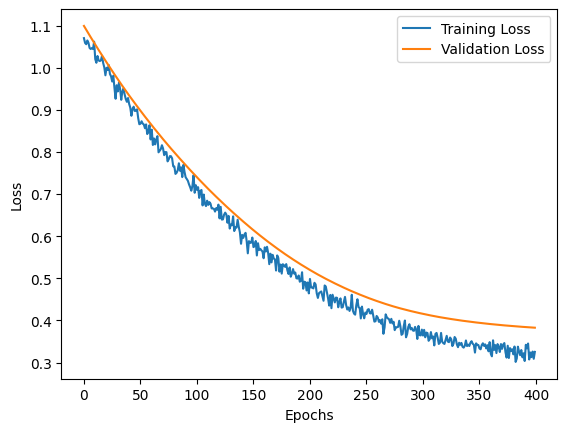

In [179]:
# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [180]:
from sklearn.metrics import r2_score
r2 = r2_score(test_dataset.y, predictions)
print(f"R-squared: {r2:.4f}")

R-squared: 0.6337


### IMPROVEMENT: Increase Learning Rate and introduce LR Scheduler

Epoch 0/400, Train Loss: 0.9896, Validation Loss: 1.0020
Epoch 10/400, Train Loss: 0.6917, Validation Loss: 0.6944
Epoch 20/400, Train Loss: 0.5019, Validation Loss: 0.5028
Epoch 30/400, Train Loss: 0.3659, Validation Loss: 0.4101
Epoch 40/400, Train Loss: 0.3424, Validation Loss: 0.3870
Epoch 50/400, Train Loss: 0.3202, Validation Loss: 0.3781
Epoch 60/400, Train Loss: 0.3054, Validation Loss: 0.3681
Epoch 70/400, Train Loss: 0.2855, Validation Loss: 0.3639
Epoch 80/400, Train Loss: 0.2854, Validation Loss: 0.3640
Epoch 90/400, Train Loss: 0.2607, Validation Loss: 0.3634
Epoch 100/400, Train Loss: 0.2514, Validation Loss: 0.3637
Epoch 110/400, Train Loss: 0.2787, Validation Loss: 0.3638
Epoch 120/400, Train Loss: 0.2648, Validation Loss: 0.3638
Epoch 130/400, Train Loss: 0.2609, Validation Loss: 0.3638
Epoch 140/400, Train Loss: 0.2694, Validation Loss: 0.3638
Epoch 150/400, Train Loss: 0.2813, Validation Loss: 0.3638
Epoch 160/400, Train Loss: 0.2634, Validation Loss: 0.3638
Epoch 17

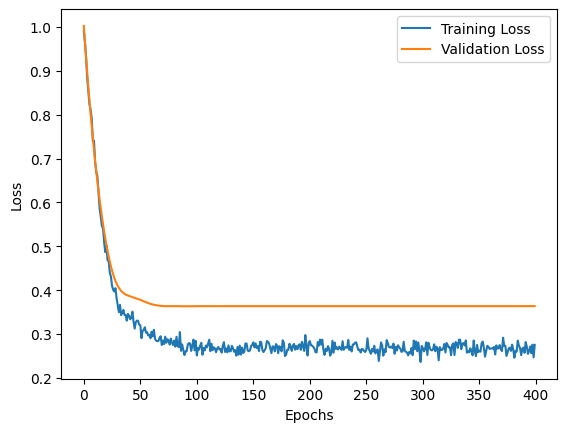

R-squared: 0.6557


In [181]:
class HouseNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(HouseNN, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)

        return x

X_train, X_val, y_train, y_val = train_test_split(train_dataset.X, train_dataset.y, test_size=0.2, random_state=42)

#Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features in the dataset
output_size = 1  # Predicting house prices (a single output)
model_h = HouseNN(input_size=input_size, output_size=output_size)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_h.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


epochs = 400

# Lists to store losses for plotting
train_losses = np.array([])
val_losses = np.array([])

for epoch in range(epochs):
    model_h.train()
    optimizer.zero_grad()
        
    pred = model_h(X_train)
    train_loss = loss_fn(pred, y_train)

    train_loss.backward()
    optimizer.step()

    model_h.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        val_pred = model_h(X_val)
        val_loss = loss_fn(val_pred, y_val)

    scheduler.step(val_loss)

    # Print training and validation loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    train_losses = np.append(train_losses, train_loss.item())
    val_losses = np.append(val_losses, val_loss.item())


model_h.eval()

with torch.no_grad():
    predictions = model_h(test_dataset.X)
    loss = loss_fn(predictions, test_dataset.y)
test_loss = loss / len(test_dataset.X)

print(f'Test Loss: {loss.item()}')

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

r2 = r2_score(test_dataset.y, predictions)
print(f"R-squared: {r2:.4f}")

### IMPROVEMENT: Increase Dropout and add L2 Regularization (Weight Decay)
- Penalizes large weights, helping the model generalize better, and increased dropout prevents overfitting.

Epoch 0/400, Train Loss: 0.9581, Validation Loss: 0.9739
Epoch 10/400, Train Loss: 0.6680, Validation Loss: 0.6638
Epoch 20/400, Train Loss: 0.5072, Validation Loss: 0.4750
Epoch 30/400, Train Loss: 0.3966, Validation Loss: 0.3909
Epoch 40/400, Train Loss: 0.3727, Validation Loss: 0.3719
Epoch 50/400, Train Loss: 0.3186, Validation Loss: 0.3639
Epoch 60/400, Train Loss: 0.3463, Validation Loss: 0.3561
Epoch 70/400, Train Loss: 0.2985, Validation Loss: 0.3530
Epoch 80/400, Train Loss: 0.3113, Validation Loss: 0.3513
Epoch 90/400, Train Loss: 0.2950, Validation Loss: 0.3511
Epoch 100/400, Train Loss: 0.3018, Validation Loss: 0.3512
Epoch 110/400, Train Loss: 0.2671, Validation Loss: 0.3513
Epoch 120/400, Train Loss: 0.2992, Validation Loss: 0.3513
Epoch 130/400, Train Loss: 0.2906, Validation Loss: 0.3513
Epoch 140/400, Train Loss: 0.2911, Validation Loss: 0.3513
Epoch 150/400, Train Loss: 0.2957, Validation Loss: 0.3513
Epoch 160/400, Train Loss: 0.3051, Validation Loss: 0.3513
Epoch 17

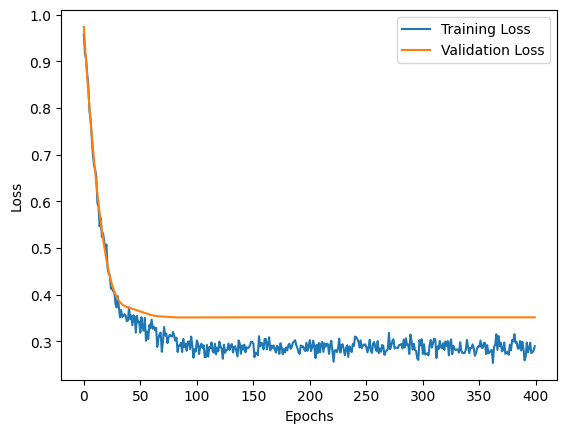

R-squared: 0.6542


In [183]:
class HouseNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(HouseNN, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(p=0.4)
    
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)

        return x

X_train, X_val, y_train, y_val = train_test_split(train_dataset.X, train_dataset.y, test_size=0.2, random_state=42)

#Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features in the dataset
output_size = 1  # Predicting house prices (a single output)
model_h = HouseNN(input_size=input_size, output_size=output_size)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_h.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


epochs = 400

# Lists to store losses for plotting
train_losses = np.array([])
val_losses = np.array([])

for epoch in range(epochs):
    model_h.train()
    optimizer.zero_grad()
        
    pred = model_h(X_train)
    train_loss = loss_fn(pred, y_train)

    train_loss.backward()
    optimizer.step()

    model_h.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        val_pred = model_h(X_val)
        val_loss = loss_fn(val_pred, y_val)

    scheduler.step(val_loss)

    # Print training and validation loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    train_losses = np.append(train_losses, train_loss.item())
    val_losses = np.append(val_losses, val_loss.item())


model_h.eval()

with torch.no_grad():
    predictions = model_h(test_dataset.X)
    loss = loss_fn(predictions, test_dataset.y)
test_loss = loss / len(test_dataset.X)

print(f'Test Loss: {loss.item()}')

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

r2 = r2_score(test_dataset.y, predictions)
print(f"R-squared: {r2:.4f}")

### IMPROVEMENT: Added Early Stopping

Epoch 0/200, Train Loss: 1.0759, Validation Loss: 1.0121
Epoch 10/200, Train Loss: 0.7808, Validation Loss: 0.7358
Epoch 20/200, Train Loss: 0.5785, Validation Loss: 0.5474
Epoch 30/200, Train Loss: 0.4394, Validation Loss: 0.4335
Epoch 40/200, Train Loss: 0.3550, Validation Loss: 0.3849
Epoch 50/200, Train Loss: 0.3969, Validation Loss: 0.3743
Epoch 60/200, Train Loss: 0.3296, Validation Loss: 0.3700
Epoch 70/200, Train Loss: 0.3578, Validation Loss: 0.3643
Epoch 80/200, Train Loss: 0.3171, Validation Loss: 0.3614
Epoch 90/200, Train Loss: 0.3348, Validation Loss: 0.3601
Epoch 100/200, Train Loss: 0.3197, Validation Loss: 0.3590
Epoch 110/200, Train Loss: 0.2875, Validation Loss: 0.3590
Epoch 120/200, Train Loss: 0.2980, Validation Loss: 0.3586
Epoch 130/200, Train Loss: 0.3008, Validation Loss: 0.3586
Early stopping at epoch 134
Test Loss: 0.5482450723648071


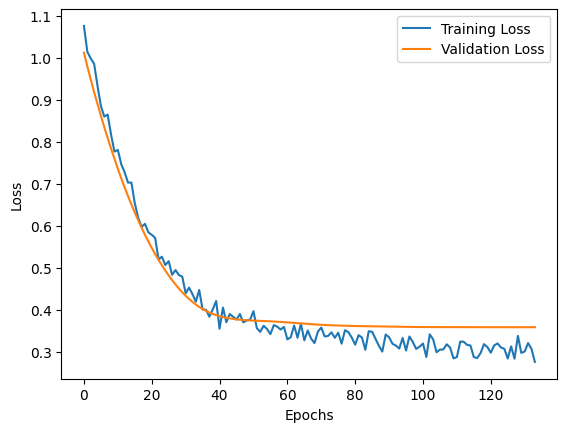

R-squared: 0.6656


In [185]:
class HouseNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(HouseNN, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)

        return x

X_train, X_val, y_train, y_val = train_test_split(train_dataset.X, train_dataset.y, test_size=0.2, random_state=42)

#Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features in the dataset
output_size = 1  # Predicting house prices (a single output)
model_h = HouseNN(input_size=input_size, output_size=output_size)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_h.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

patience = 10  # Stop training after 10 epochs of no improvement
best_val_loss = float('inf')
epochs_no_improve = 0
epochs = 200

# Lists to store losses for plotting
train_losses = np.array([])
val_losses = np.array([])

for epoch in range(epochs):
    model_h.train()
    optimizer.zero_grad()
        
    pred = model_h(X_train)
    train_loss = loss_fn(pred, y_train)

    train_loss.backward()
    optimizer.step()

    model_h.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        val_pred = model_h(X_val)
        val_loss = loss_fn(val_pred, y_val)

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    scheduler.step(val_loss)

    # Print training and validation loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    train_losses = np.append(train_losses, train_loss.item())
    val_losses = np.append(val_losses, val_loss.item())


model_h.eval()

with torch.no_grad():
    predictions = model_h(test_dataset.X)
    loss = loss_fn(predictions, test_dataset.y)
test_loss = loss / len(test_dataset.X)

print(f'Test Loss: {loss.item()}')

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

r2 = r2_score(test_dataset.y, predictions)
print(f"R-squared: {r2:.4f}")

Epoch 0/200, Train Loss: 1.1574, Validation Loss: 1.0833
Epoch 10/200, Train Loss: 0.8340, Validation Loss: 0.7757
Epoch 20/200, Train Loss: 0.5692, Validation Loss: 0.5672
Epoch 30/200, Train Loss: 0.4369, Validation Loss: 0.4408
Epoch 40/200, Train Loss: 0.3814, Validation Loss: 0.3865
Epoch 50/200, Train Loss: 0.3395, Validation Loss: 0.3761
Epoch 60/200, Train Loss: 0.3452, Validation Loss: 0.3710
Epoch 70/200, Train Loss: 0.3214, Validation Loss: 0.3635
Epoch 80/200, Train Loss: 0.3345, Validation Loss: 0.3570
Epoch 90/200, Train Loss: 0.3137, Validation Loss: 0.3535
Epoch 100/200, Train Loss: 0.3047, Validation Loss: 0.3516
Epoch 110/200, Train Loss: 0.2728, Validation Loss: 0.3513
Epoch 120/200, Train Loss: 0.3092, Validation Loss: 0.3514
Early stopping at epoch 124
Test Loss: 0.5549452304840088


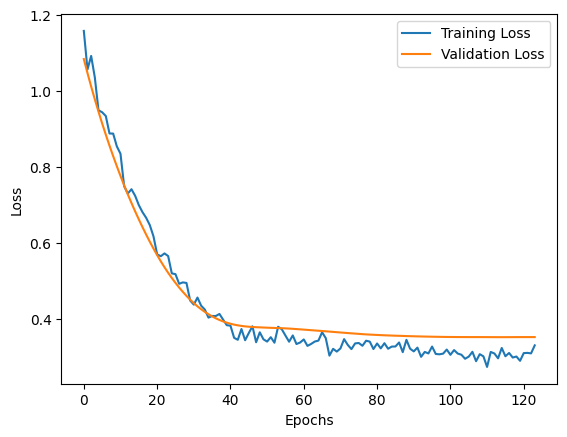

R-squared: 0.6615


In [240]:
class HouseNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(HouseNN, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)

        return x

X_train, X_val, y_train, y_val = train_test_split(train_dataset.X, train_dataset.y, test_size=0.2, random_state=42)

#Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features in the dataset
output_size = 1  # Predicting house prices (a single output)
model_h = HouseNN(input_size=input_size, output_size=output_size)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_h.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

patience = 10  # Stop training after 10 epochs of no improvement
best_val_loss = float('inf')
epochs_no_improve = 0
epochs = 200

# Lists to store losses for plotting
train_losses = np.array([])
val_losses = np.array([])

for epoch in range(epochs):
    model_h.train()
    optimizer.zero_grad()
        
    pred = model_h(X_train)
    train_loss = loss_fn(pred, y_train)

    train_loss.backward()
    optimizer.step()

    model_h.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        val_pred = model_h(X_val)
        val_loss = loss_fn(val_pred, y_val)

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    scheduler.step(val_loss)

    # Print training and validation loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    train_losses = np.append(train_losses, train_loss.item())
    val_losses = np.append(val_losses, val_loss.item())


model_h.eval()

with torch.no_grad():
    predictions = model_h(test_dataset.X)
    loss = loss_fn(predictions, test_dataset.y)
test_loss = loss / len(test_dataset.X)

print(f'Test Loss: {loss.item()}')

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

r2 = r2_score(test_dataset.y, predictions)
print(f"R-squared: {r2:.4f}")